# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Описание данных**

* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

**План работы** 

1. Обзор данных


2. Предобработка данных
- Обработка пропусков и аномальных значений
- Исправить тип данных
- Удалить дубликаты
- Выдклить леммы
- Категоризировать данные

3. Ответы на основные вопросы заказчика исследования
- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

4. Результаты 
- Выводы
- Рекомендации

## Шаг 1. Откройте файл с данными и изучите общую информацию

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import pprint

from pymystem3 import Mystem
from collections import Counter

Откроем датасет, посмотрим его основную информацию, а также его начало и конец.

In [2]:
df = pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
df.tail(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21510,2,NaN,28,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,приобретение автомобиля
21511,0,-612.569129,29,высшее,0,гражданский брак,1,F,сотрудник,1,140068.472941,покупка жилья для сдачи
21512,0,-165.377752,26,высшее,0,Не женат / не замужем,4,M,компаньон,0,147301.457769,получение дополнительного образования
21513,0,-1166.216789,35,среднее,1,женат / замужем,0,F,сотрудник,0,250986.142309,покупка жилья
21514,0,-280.469996,27,неоконченное высшее,2,Не женат / не замужем,4,M,компаньон,0,355988.407188,строительство недвижимости
21515,1,-467.685130,28,среднее,1,женат / замужем,0,F,сотрудник,1,109486.327999,заняться образованием
21516,0,-914.391429,42,высшее,0,женат / замужем,0,F,компаньон,0,322807.776603,покупка своего жилья
21517,0,-404.679034,42,высшее,0,гражданский брак,1,F,компаньон,0,178059.553491,на покупку своего автомобиля
21518,0,373995.710838,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем
21519,1,-2351.431934,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости


In [5]:
#Посмотрим какие отклонения есть в датасете
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Вывод**

Предстоит решить следующие проблемы:
- отрицательные значения в днях стажа и детях
- неточность данных в днях стажа (слишком большие значения)
- дни стажа логичнее перевести в года для удобства восприятия
- отсутствуют значения (есть строки NaN) в днях стажа и доходе
- значения в доходе корректнее привести к целому значению
- в столбце возраст присутствуют нулевые значения
- значение "20" в столбце дети аномально, вероятно ошибка
- разный регистр букв
- быть готовым к появлению дополнительных проблем 

## Шаг 2. Предобработка данных

### Обработка пропусков и аномальных значений

In [6]:
#Узнаем сколько всего пропусков и где
df.isnull().sum()
#Узнаем сколько всего пропусков и где


children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски только в двух столбцах. При этом в днях стажа и ежемесячном доходе одинаковое количество пропусков. Это может быть связано с тем, что часть клиентов не работали и соответственно не получали зарплату

Для ответов на поставленные в исследовани вопросы, нужно внимательнее изучить и скорретировать столбцы:
- children
- family_status_id
- total_income
- purpose
- debt

Приступим

Начнем по порядку с children.  
В ознакомительной части мы выяснили, что есть аномальные и отрицательные значения. Проверим внимательные эти значения и скорректируем данные.

In [7]:
#Посмотрим уникальные значения
df['children'].unique().tolist()

[1, 0, 3, 2, -1, 4, 20, 5]

In [8]:

print("Заявок с значением -1 в столбце дети:", df[df['children'] == -1].count()[0])
print("Заявок с значением 20 в столбце дети:", df[df['children'] == 20].count()[0])
print("Всего заявок со значением 20 в столбце дети:", len(df[df['children'] == 20]['total_income'].unique()))

Заявок с значением -1 в столбце дети: 47
Заявок с значением 20 в столбце дети: 76
Всего заявок со значением 20 в столбце дети: 68


68 уникальных заявок со значением 20 детей похожи на человеческую ошибку, изменим это значение на 2.  
А отрицательное значение -1 заменим на 1.

In [9]:
df['children'] = df['children'].replace(-1, 1)
df['children'] = df['children'].replace(20, 2)
#Проверим изменения
df['children'].unique().tolist()

[1, 0, 3, 2, 4, 5]

Данные по детям обработаны, продолжин с графой о семеном положении.

In [10]:
#Посмотрим уникальные значения 
df['family_status'].unique().tolist()

['женат / замужем',
 'гражданский брак',
 'вдовец / вдова',
 'в разводе',
 'Не женат / не замужем']

In [11]:
df['family_status_id'].unique().tolist()

[0, 1, 2, 3, 4]

Приведем значения к нижнему регистру

In [12]:
df['family_status'] = df['family_status'].str.lower()


Теперь разберемся со значениями в столбце об уровне доходов.  
Как помним, у нас там есть значения NaN. Мы предположили, что это может быть связано с тем, что часть клиентов не работали и соответственно не получали зарплату. Проверим нашу гипотезу.

In [13]:
#Проверим, отсутствуют данные по обоим столбцам 'days_employed' и 'total_income' в одинаковых строках или разных.
#Пропущенные значения должны быть в обоих столбцах в одной строке
df[(df['total_income'].isnull() == True) & (df['days_employed'].isnull() == True)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
children            2174 non-null int64
days_employed       0 non-null float64
dob_years           2174 non-null int64
education           2174 non-null object
education_id        2174 non-null int64
family_status       2174 non-null object
family_status_id    2174 non-null int64
gender              2174 non-null object
income_type         2174 non-null object
debt                2174 non-null int64
total_income        0 non-null float64
purpose             2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Гипотеза подтвердилась. Данные не заполнены в 2 столбцах одновременно.

Посомтрим, люди каких профессий не заполняли данные о доходе и стаже.

In [14]:
df[(df['total_income'].isnull() == True) & (df['days_employed'].isnull() == True)]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Доход не указан для разных профессий, в которых разный уровень дохода, поэтому корректнее будет заменить пропущенные значения средним медиальным значением с группировкой по типу занятости.

In [15]:
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))

In [16]:
#Проверяем, как прошла замена
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64

In [17]:
#В стаже есть отрицательные значения. Причина их появления неясна, на это нужно обратить внимание сотрудников банка
#Исправим это
df['days_employed'] = df['days_employed'].abs()

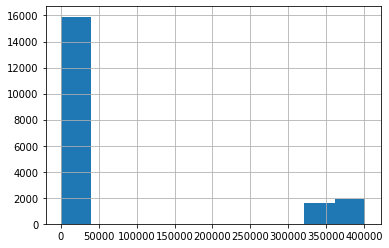

In [43]:
df['days_employed'].hist();

In [18]:
#В столбце образование используется разный регистр
#Приведем к единому написанию нижним регистром
df['education'] = df['education'].str.lower()
df['education'].unique().tolist()

['высшее', 'среднее', 'неоконченное высшее', 'начальное', 'ученая степень']

**Вывод**  

Нам удалось обработать данные, которые будут необходимы в дальнейшем для ответов на поставленные в начале исследования вопросы.

### Замена типа данных

In [19]:
#Заменим тип данных в столбцах стажа и дохода, чтобы убрать лишние цифры после запятой
df['days_employed'] = df['days_employed'].round().astype('Int64')
df['total_income'] = df['total_income'].round().astype('Int64')

In [20]:
#Проверим замену типа данных 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null Int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null Int64
purpose             21525 non-null object
dtypes: Int64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [21]:
#Посмотрим, как теперь отображаются данные о стаже и доходе
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи


**Вывод**

В нашем анализе цифры после запятой в данных столбцах значения не имеют, а визуально они мешают воспринимать информацию.  
Привести их к целочисленному виду хорошее решение.  
Мы не стали пока глубоко корректировать значения тех столбцов, которые не понадобятся нам для ответов на ключевые вопросы. Лучше потратим время и силы на главное.

### Обработка дубликатов

In [22]:
#Проверяем наличие дублей
df.duplicated().sum()

71

In [23]:
#Посмотрим, как они выглядят
df[df.duplicated(keep=False)].sort_values(by=['purpose', 'total_income'])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
8178,0,NaN,64,среднее,1,женат / замужем,0,F,пенсионер,0,118514,автомобиль
13639,0,NaN,64,среднее,1,женат / замужем,0,F,пенсионер,0,118514,автомобиль
120,0,NaN,46,среднее,1,женат / замужем,0,F,сотрудник,0,142594,высшее образование
16378,0,NaN,46,среднее,1,женат / замужем,0,F,сотрудник,0,142594,высшее образование
1511,0,NaN,58,высшее,0,не женат / не замужем,4,F,пенсионер,0,118514,дополнительное образование
...,...,...,...,...,...,...,...,...,...,...,...,...
16902,2,NaN,39,среднее,1,гражданский брак,1,F,сотрудник,0,142594,сыграть свадьбу
18521,0,NaN,56,среднее,1,гражданский брак,1,F,сотрудник,0,142594,сыграть свадьбу
20297,1,NaN,23,среднее,1,гражданский брак,1,F,сотрудник,0,142594,сыграть свадьбу
5124,0,NaN,40,среднее,1,гражданский брак,1,F,компаньон,0,172358,сыграть свадьбу


Как видим, дубли действительно очень похожи на задвоение заявок. Можем удалять.

In [24]:
#Удаляем дубли и перезаписываем индекс
df = df.drop_duplicates().reset_index(drop=True)

In [25]:
#Проверяем, как выполнилось удаление дублей
df.duplicated().sum()

0

**Вывод**
Удалили дубликаты, котрые могли исказить результаты исследования и привести к некорректным выводам.  
Появление дублирующих заявок можно объяснить повторными обращениями, которые еще не успели обработать или техническими ошибками, так как сотрудники банка или сама система должны удалять предыдущие заявки от одного и того же клиента

### Лемматизация

Для указания цели кредита не было единого списка целей., поэтому люди писали своими словами. Для анализа возвратности по целям кредита, нам необходимо проанализировать ответы в заявках и собрать их в общие по целям группы.  
Приступаем к выявлению лемм.

In [26]:
#Посмотрим что и в каком количестве писали клиенты о своих целях кредита 
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Мы можем уже визуально выделить 4 основные цели кредитов: свадьба, недвижимость/жилье, автомобиль и образование.  
Можем, но лучше перепроверить и вызвать функцию лемматизации, чтобы получить рейтинг лемм.  

In [27]:
#Выделим леммы в значениях столбца с целями получения кредита
m = Mystem()
lemmas_list = []
for element in df['purpose']:
    lemma = m.lemmatize(element)
    lemmas_list.extend(lemma)

unique_lemmas = Counter(lemmas_list)
sorted(unique_lemmas.items(), key = lambda pair: pair[1], reverse=True)


[(' ', 33570),
 ('\n', 21454),
 ('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1230),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заниматься', 904),
 ('проведение', 768),
 ('сыграть', 765),
 ('сдача', 651),
 ('семья', 638),
 ('собственный', 635),
 ('со', 627),
 ('ремонт', 607),
 ('подержанный', 486),
 ('подержать', 478),
 ('приобретение', 461),
 ('профильный', 436)]

In [28]:
#Напишем функцию для лемматизации целей кредита
def lemma_group (purpose):
    lemmas = ' '.join(m.lemmatize(purpose))
    if 'автомоб' in lemmas:
        return 'покупка автомобиля'
    elif ('недвиж' in lemmas) or ('жиль' in lemmas):
        return 'покупка недвижимости'
    elif 'свадьб' in lemmas:
        return 'свадьба'
    elif 'образован' in lemmas:
        return 'образование'
    else:
        return 'другая цель кредита'

In [29]:
#Применяем  функцию лемматизации к столбцу purpose и добавляем новый столбец с леммами purpose_category
df['purpose_group']=df['purpose'].apply(lemma_group)

In [30]:
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья,покупка недвижимости
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,покупка автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,покупка недвижимости
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья,покупка недвижимости
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем,покупка недвижимости
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование,образование
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы,свадьба
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи,покупка недвижимости


In [31]:
#Посмотрим количество заявок по каждой цели кредита
purposes=df.groupby('purpose_group')['purpose_group'].count()
purposes.sort_values(ascending = False)

purpose_group
покупка недвижимости    10811
покупка автомобиля       4306
образование              4013
свадьба                  2324
Name: purpose_group, dtype: int64

**Вывод**

С помощью лемматизации нам удалось выделить из общей массы ответов четкий список, состоящий из 4 основных целей кредита. Полученные данные необходимы нам для дальнейшего анализа возвратности по целям кредита.  
Как видим, почти половина заемщиков планирует приобрести недвижиость. Квартирный вопрос, как всегда, актуален.

### Категоризация данных

С целями кредита мы уже разобрались чуть выше, теперь займемся доходами.

Для удобства исследования необходимо разбить данные о доходах на группы, желательно на равные группы, чтобы было репрезентативно.  
Разделить данные на сегменты одинакового размера поможет функция .qcut()  
В аргументе укажем значение 5. Группировка на 4-5 значений в нашем случае будет оптимальна.

In [32]:
income_cut = pd.qcut(df['total_income'], 5)
income_cut.value_counts()

(214618.2, 2265604.0]    4291
(161335.8, 214618.2]     4291
(98538.6, 132135.2]      4291
(20666.999, 98538.6]     4291
(132135.2, 161335.8]     4290
Name: total_income, dtype: int64

Пороговые значения определены, можем написать функцию категоризации и добавить новый столбец.

In [33]:
def income_group(total_income):
    if total_income < 98538.6:
        return('низкие доходы')
    if 98538.6 <= total_income < 132135.2:
        return('средние доходы')
    if 132135.2 <= total_income <= 161335.8:
        return('повышенные доходы')
    if 161335.8 <= total_income <= 214618.2:
        return('высокие доходы')
    
    return('сверхвысокие доходы')

In [34]:
df['income_group']=df['total_income'].apply(income_group)

Произведем группировку по количеству детей и добавим новый столбец.  
Наиболее логичной будет группировка на 3 категории: без детей, многодетный клиент 3+ и клиент с 1-2 детьми.

In [35]:
def children_group(row):
    if row['children'] == 0:
        return 'нет детей'
    elif 1 <= row['children'] <= 2:
        return '1-2 ребенка'
    else:
        return 'многодетный клиент'

In [36]:
df['children_group'] = df.apply(children_group, axis=1)

In [37]:
#Проверим наши новые столбцы с категориями
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group,income_group,children_group
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья,покупка недвижимости,сверхвысокие доходы,1-2 ребенка
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,покупка автомобиля,средние доходы,1-2 ребенка
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,покупка недвижимости,повышенные доходы,нет детей
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование,образование,сверхвысокие доходы,многодетный клиент
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,повышенные доходы,нет детей
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья,покупка недвижимости,сверхвысокие доходы,нет детей
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем,покупка недвижимости,сверхвысокие доходы,нет детей
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование,образование,повышенные доходы,нет детей
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы,свадьба,низкие доходы,1-2 ребенка
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи,покупка недвижимости,повышенные доходы,нет детей


**Вывод**

Для ответов на посставленые в исследовании главные вопросы нам было необходимо объеденить часть данных в категории (уровень дохода, количество детей и цели кредита). С чем мы успешно справились, можем приступать к заключительной части исследования.  
На будущее, можно посоветовать банку добавлять данные категории автоматически, при заполнении заявки. Автоматизация процессов экономит время и деньги.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [38]:
#Построим сводную таблицу связи между наличием детей и возвратом кредита в срок
pivot_table_children = df.pivot_table(index='children_group', columns= 'debt', values='days_employed', aggfunc='count')
pivot_table_children['ratio'] = pivot_table_children[1] / (pivot_table_children[1] + pivot_table_children[0]) * 100
pivot_table_children.columns = ['Без задолженности','С задолженностью','% должников']
pivot_table_children

,Без задолженности,С задолженностью,% должников
children_group,,,
1-2 ребенка,5711,594,9.421094
многодетный клиент,311,25,7.440476
нет детей,11758,952,7.490165


**Вывод**

Клиенты без детей, как и многодетные менее склонны к просрочке по выплатам кредита.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [39]:
#Построим сводную таблицу связи между семейным положением и возвратом кредита в срок
pivot_table_family = df.pivot_table(index='family_status', columns= 'debt', values='days_employed', aggfunc='count')
pivot_table_family['ratio'] = pivot_table_family[1] / (pivot_table_family[1] + pivot_table_family[0]) * 100
pivot_table_family.columns = ['Без задолженности','С задолженностью','% должников']
pivot_table_family.sort_values(by = '% должников', ascending = False)

,Без задолженности,С задолженностью,% должников
family_status,,,
не женат / не замужем,2271,254,10.059406
гражданский брак,3396,339,9.076305
женат / замужем,10297,846,7.592210
в разводе,1007,76,7.017544
вдовец / вдова,809,56,6.473988


**Вывод**

Зависимость между семейным положением и возвратом кредита в срок есть. Клиенты не состоящие и не состояышие ранее в браке более склонны к наличию задолженности по возврату кредита. Клиенты находящиеся в разводе и овдовевшие имеют меньше % задолженностей перед банком.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [40]:
#Построим сводную таблицу связи между уровнем дохода и возвратом кредита в срок
pivot_table_income = df.pivot_table(index='income_group', columns= 'debt', values='days_employed', aggfunc='count')
pivot_table_income['ratio'] = pivot_table_income[1] / (pivot_table_income[1] + pivot_table_income[0]) * 100
pivot_table_income.columns = ['Без задолженности','С задолженностью','% должников']
pivot_table_income.sort_values(by = '% должников', ascending = False)

,Без задолженности,С задолженностью,% должников
income_group,,,
повышенные доходы,2805,270,8.780488
высокие доходы,3459,331,8.733509
средние доходы,3579,326,8.348271
низкие доходы,3947,344,8.016779
сверхвысокие доходы,3990,300,6.993007


**Вывод**

Клиенты со сверхвысоким уровнем доходов менее склонны иметь просрочки по кредитам.  
У остальных групп примерно одинаковые значения % наличия просрочки, но среди них клиенты с самыми низкими из рассматриваемых доходами имеют меньше % задолженности по возврату кредитов

- Как разные цели кредита влияют на его возврат в срок?

In [41]:
#Построим сводную таблицу связи между целью кредита и возвратом кредита в срок
pivot_table_purpose = df.pivot_table(index='purpose_group', columns= 'debt', values='days_employed', aggfunc='count')
pivot_table_purpose['ratio'] = pivot_table_purpose[1] / (pivot_table_purpose[1] + pivot_table_purpose[0]) * 100
pivot_table_purpose.columns = ['Без задолженности','С задолженностью','% должников']
pivot_table_purpose.sort_values(by = '% должников', ascending = False)

,Без задолженности,С задолженностью,% должников
purpose_group,,,
покупка автомобиля,3530,367,9.417501
образование,3266,331,9.202113
свадьба,1941,158,7.527394
покупка недвижимости,9043,715,7.327321


**Вывод**

Клиенты, взявшие кредит на покупку недвижимости и проведение свадьбы менее склонны иметь задолженность по выплатам перед банком.  

## Шаг 4. Общий вывод

In [42]:
"Средняя просрочка по клиентской базе: %.2f" % ((df['debt'].sum()/len(df)*100)), '%'

('Средняя просрочка по клиентской базе: 8.12', '%')

Относительно средней величины наличия задолженности по возврату кредитов все наши изыскания колеблются в диапазоне +-2%.  
Для банка это может иметь существенное значение, так суммы оборота кредитных средств весьма внушительные.  
Проведенное исследование поможет банку принять взвешенное решение, оценив риски для категорий клиентов с отклонением значения задолженности в большую сторону. Чтобы компенсировать риски банк может применить защитные механизмы, например, повышенную ставку для рискованных категорий или предложить услуги страхования от невыплаты.  
Также данные исследования могут быть использованы службой маркетинга, например для корректировки целевой аудитории в рекламных компаниях.